In [7]:
# autoreload
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gmean, gstd
from matplotlib import pyplot as plt

import viz
colors = viz.plotting_style()

# load the style file for mpl 
plt.style.use('style.mpl')

Duplicate key in file 'style.mpl', line 17 ('axes.titlesize : 9')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# units are gC/m2/yr
srdb = pd.read_csv('../data/SRDB_V5_1827/data/srdb-data-V5.csv')
srdb_studies = pd.read_csv('../data/SRDB_V5_1827/data/srdb-studies-V5.csv', encoding = "ISO-8859-1")
srdb_equations = pd.read_csv('../data/SRDB_V5_1827/data/srdb-equations-V5.csv', encoding = "ISO-8859-1")

# Entry_date is a date-time in the format 'YYYY-MM-DD'
srdb['Entry_datetime'] = pd.to_datetime(srdb['Entry_date'], format='%Y-%m-%d')

# Fetch the year of publication via "Study_number"
srdb['measured_year'] = srdb_studies.set_index('Study_number').loc[srdb['Study_number'], 'PubYear'].values

/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_265/2140980518.py:2: DtypeWarning: Columns (4,39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  srdb = pd.read_csv('../data/SRDB_V5_1827/data/srdb-data-V5.csv')


In [9]:
srdb.columns

Index(['Record_number', 'Entry_date', 'Study_number', 'Author',
       'Duplicate_record', 'Quality_flag', 'Contributor', 'Country', 'Region',
       'Site_name', 'Site_ID', 'Study_midyear', 'YearsOfData', 'Latitude',
       'Longitude', 'Elevation', 'Manipulation', 'Manipulation_level',
       'Age_ecosystem', 'Age_disturbance', 'Species', 'Biome',
       'Ecosystem_type', 'Ecosystem_state', 'Leaf_habit', 'Stage', 'Soil_type',
       'Soil_drainage', 'Soil_BD', 'Soil_CN', 'Soil_sand', 'Soil_silt',
       'Soil_clay', 'MAT', 'MAP', 'PET', 'Study_temp', 'Study_precip',
       'Meas_method', 'Collar_height', 'Collar_depth', 'Chamber_area',
       'Time_of_day', 'Meas_interval', 'Annual_coverage', 'Partition_method',
       'Rs_annual', 'Rs_annual_err', 'Rs_interann_err', 'Rlitter_annual',
       'Ra_annual', 'Rh_annual', 'RC_annual', 'Rs_spring', 'Rs_summer',
       'Rs_autumn', 'Rs_winter', 'Rs_growingseason', 'Rs_wet', 'Rs_dry',
       'RC_seasonal', 'RC_season', 'GPP', 'ER', 'NEP', 'N

In [10]:
mask = np.logical_and(srdb.Rs_annual.notnull(), srdb.Manipulation.notnull())
srdb[mask].Manipulation

33       Fertilized
35       Fertilized
37       Fertilized
53              CO2
54              CO2
            ...    
10280    Fertilized
10281    Fertilized
10282    Fertilized
10283    Fertilized
10284    Fertilized
Name: Manipulation, Length: 1804, dtype: object

In [11]:
srdb_equations.WC_effect.unique()

array([nan, 'Negative', 'Positive', 'Mixed'], dtype=object)

median Q10: 2.61


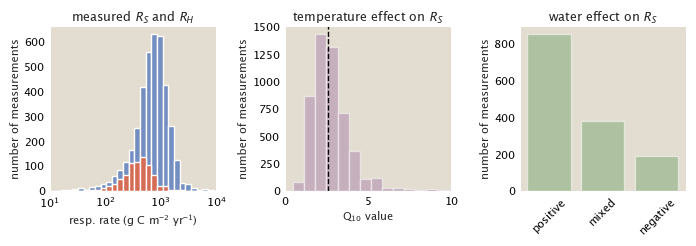

In [16]:
mosaic = "ABC"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7, 2.5))

plt.sca(axs['A'])
plt.xscale('log')
bins = np.logspace(1,6,50)
mask = srdb.Manipulation.isnull()
plt.hist(srdb[mask].Rs_annual, bins=bins, edgecolor='w', lw=1, color=colors['blue'])
plt.hist(srdb[mask].Rh_annual, bins=bins, edgecolor='w', lw=1, color=colors['red'])

plt.xlabel('resp. rate (g C m$^{-2}$ yr$^{-1}$)')
plt.ylabel('number of measurements')
plt.xlim(10, 1e4)
plt.title(f'measured $R_S$ and $R_H$')

plt.sca(axs['B'])
# lump together all the Q10 values over the 10 C ranges 
# Q10_0_10, Q10_5_15, Q10_10_20

vals = np.concatenate([srdb_equations.Q10_0_10, srdb_equations.Q10_5_15, srdb_equations.Q10_10_20])
median = np.nanmedian(vals)
print(f'median Q10: {median:.2f}')
plt.hist(vals, bins=50, color=colors['purple'], alpha=0.5)
plt.axvline(median, color='k', ls='--', lw=1, label='median')

plt.xlabel('Q$_{10}$ value')
plt.ylabel('number of measurements')
plt.title('temperature effect on $R_S$')
plt.xlim(0, 10)
plt.xticks(np.arange(0, 11, 5))

plt.sca(axs['C'])

# bar plot counting the values for WC_effect, which has values 
# of nan, 'Negative', 'Positive', 'Mixed'

wc_effect = srdb_equations.WC_effect.value_counts()
wc_effect = wc_effect[wc_effect.index != 'nan']
plt.bar(wc_effect.index, wc_effect.values, color=colors['green'], alpha=0.5)
plt.title('water effect on $R_S$')
plt.ylabel('number of measurements')
plt.xticks(np.arange(len(wc_effect.index)), wc_effect.index.str.lower(), rotation=45)
plt.tight_layout()

plt.show()

In [17]:
# Fit rs and rh to a lognormal distribution using scipy
from scipy.stats import lognorm
from scipy.stats import kstest

def fit_lognormal(data):
    # Fit a lognormal distribution to the data
    shape, loc, scale = lognorm.fit(data, floc=0)
    # Calculate the mean and standard deviation of the fitted distribution
    mean = np.exp(np.log(scale) + 0.5 * shape**2)
    std = np.sqrt((np.exp(shape**2) - 1) * np.exp(2 * np.log(scale) + shape**2))
    median = np.exp(np.log(scale))
    return shape, loc, scale, median, mean, std


# Fit the lognormal distribution to Rs_annual and Rh_annual
mask_Rs = np.logical_and(srdb.Rs_annual.notnull(), srdb.Rs_annual > 0)
mask_Rh = np.logical_and(srdb.Rs_annual.notnull(), srdb.Rh_annual > 0)
Rs_shape, Rs_loc, Rs_scale, Rs_mean, Rs_median, Rs_std = fit_lognormal(srdb[mask_Rs].Rs_annual)
Rh_shape, Rh_loc, Rh_scale, Rh_mean, Rh_median, Rh_std = fit_lognormal(srdb[mask_Rh].Rh_annual)
print(f"Rs_annual: shape={Rs_shape}, loc={Rs_loc}, scale={Rs_scale}, median={Rs_median}, mean={Rs_mean}, std={Rs_std}")
print(f"Rh_annual: shape={Rh_shape}, loc={Rh_loc}, scale={Rh_scale}, median={Rh_median}, mean={Rh_mean}, std={Rh_std}")
# Perform the Kolmogorov-Smirnov test
Rs_statistic, Rs_p_value = kstest(srdb.Rs_annual.dropna(), 'lognorm', args=(Rs_shape, Rs_loc, Rs_scale))
Rh_statistic, Rh_p_value = kstest(srdb.Rh_annual.dropna(), 'lognorm', args=(Rh_shape, Rh_loc, Rh_scale))
print(f"Rs_annual: KS statistic={Rs_statistic}, p-value={Rs_p_value}")
print(f"Rh_annual: KS statistic={Rh_statistic}, p-value={Rh_p_value}")

# Calculate the raw medians and means for both
Rs_annual = srdb[mask_Rs].Rs_annual
Rh_annual = srdb[mask_Rh].Rh_annual
Rs_median_raw = np.median(Rs_annual)
Rh_median_raw = np.median(Rh_annual)
Rs_mean_raw = np.mean(Rs_annual)
Rh_mean_raw = np.mean(Rh_annual)
print(f"Rs_annual: raw median={Rs_median_raw}, raw mean={Rs_mean_raw}")
print(f"Rh_annual: raw median={Rh_median_raw}, raw mean={Rh_mean_raw}")



Rs_annual: shape=0.7485556908065243, loc=0, scale=675.1524306465097, median=893.464229513466, mean=675.1524306465097, std=774.4124923472046
Rh_annual: shape=0.6826748920191539, loc=0, scale=388.7300620598252, median=490.7366742633611, mean=388.7300620598252, std=378.11530682777294
Rs_annual: KS statistic=0.0721302221894029, p-value=2.028019905200937e-26
Rh_annual: KS statistic=0.06925611439942442, p-value=7.994476254878812e-05
Rs_annual: raw median=732.0, raw mean=854.9038691290991
Rh_annual: raw median=420.0, raw mean=479.31325495190845


In [18]:
# Calculate the raw mean and medians of the Q10 values
Q10_0_10 = srdb_equations.Q10_0_10
Q10_5_15 = srdb_equations.Q10_5_15
Q10_10_20 = srdb_equations.Q10_10_20
Q10_0_10_median = np.nanmedian(Q10_0_10)
Q10_5_15_median = np.nanmedian(Q10_5_15)
Q10_10_20_median = np.nanmedian(Q10_10_20)
Q10_0_10_mean = np.mean(Q10_0_10)
Q10_5_15_mean = np.mean(Q10_5_15)
Q10_10_20_mean = np.mean(Q10_10_20)

print(f"Q10_0_10: raw median={Q10_0_10_median}, raw mean={Q10_0_10_mean}")
print(f"Q10_5_15: raw median={Q10_5_15_median}, raw mean={Q10_5_15_mean}")
print(f"Q10_10_20: raw median={Q10_10_20_median}, raw mean={Q10_10_20_mean}")

Q10_0_10: raw median=2.72, raw mean=3.270743187645208
Q10_5_15: raw median=2.7, raw mean=2.981456135863317
Q10_10_20: raw median=2.404838923, raw mean=2.6289841030129266


In [19]:
mask = srdb.Rh_annual > 0
rh_gmean = gmean(srdb[mask].Rh_annual)
rh_gstd = gstd(srdb[mask].Rh_annual)
print(f"Geometric mean Rh: {rh_gmean:.2f} g C/m2/yr")
print(f"Geometric std Rh: {rh_gstd:.2f} fold")

rh_mean = srdb[mask].Rh_annual.mean()
rh_std = srdb[mask].Rh_annual.std()
print(f"Mean Rh: {rh_mean:.2f} g C/m2/yr")
print(f"Std Rh: {rh_std:.2f} g C/m2/yr")

Geometric mean Rh: 390.27 g C/m2/yr
Geometric std Rh: 2.02 fold
Mean Rh: 480.41 g C/m2/yr
Std Rh: 340.86 g C/m2/yr
